## Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [397]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [398]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [399]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-10 00:58:55--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-10 00:58:56--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [400]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [401]:
CUDA_DEVICE_ID = 0  # change if needed

In [402]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

In [403]:
device

device(type='cuda', index=0)

In [404]:
# global_mean = 0
# for imgs, labels in train_data_loader:
#   global_mean += imgs.sum()

# global_mean /= len(train_fmnist_data) * 28 * 28

# global_var = 0
# for imgs, labels in train_data_loader:
#   global_var += ((imgs - global_mean) ** 2).sum()

# global_var /= len(train_fmnist_data) * 28 * 28
# global_std = torch.sqrt(global_var)

In [371]:
global_mean, global_std

(tensor(0.2860), tensor(0.3530))

Text(0.5, 1.0, 'Image label: 6')

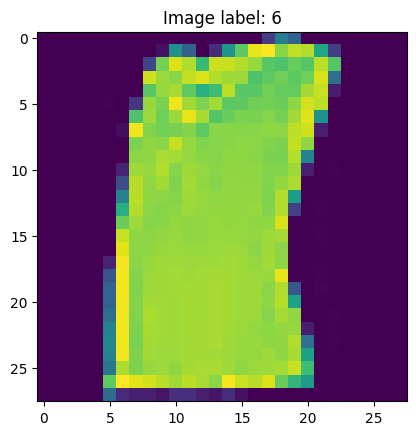

In [405]:
# do not change the code in the block below
# __________start of block__________

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.286], std=[0.353])
])

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=transform, download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=transform, download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [406]:
torch.__version__

'2.6.0+cu124'

In [407]:
class MyModel(nn.Module):
    def __init__(self, dropout_p=0.3):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 128 * 3 * 3)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [408]:
# Creating model instance
model_task_1 = MyModel()

Не забудьте перенести модель на выбранный `device`!

In [409]:
model_task_1.to(device)

MyModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

Локальные тесты для проверки вашей модели доступны ниже:

In [410]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [411]:
loss_fn = nn.CrossEntropyLoss()

In [418]:
def train_one_epoch(model, optimizer):
  model.train()
  train_loss = 0
  epoch_all = 0
  epoch_correct = 0

  for imgs, labels in train_data_loader:
    imgs, labels = imgs.to(device), labels.to(device)

    optimizer.zero_grad()

    outs = model(imgs)
    loss = loss_fn(outs, labels)
    loss.backward()
    train_loss += loss.item()

    preds = outs.argmax(-1)
    correct = (preds == labels).sum().item()
    batch_size = labels.size(0)
    epoch_correct += correct
    epoch_all += batch_size

    optimizer.step()

  epoch_accuracy = epoch_correct / epoch_all
  epoch_loss = train_loss / len(train_data_loader)

  return epoch_loss, epoch_accuracy

In [419]:
# список названий классов FashionMNIST
classes = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

def evaluate_per_class_accuracy(preds, labels):
    correct = [0] * 10
    total = [0] * 10

    for label, pred in zip(labels, preds):
        total[label] += 1
        if label == pred:
            correct[label] += 1

    for i in range(10):
        if total[i] > 0:
            acc = 100 * correct[i] / total[i]
        else:
            acc = 0.0
        print(f"Accuracy of class {i} ({classes[i]:13s}): {acc:.2f}% ({correct[i]}/{total[i]})")


def val_one_epoch(model, verbose=False):
    model.eval()
    val_loss = 0
    epoch_correct = 0
    epoch_all = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outs = model(imgs)
            val_loss += loss_fn(outs, labels).item()

            preds = outs.argmax(dim=1)

            epoch_correct += (preds == labels).sum().item()
            epoch_all += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    if verbose:
      evaluate_per_class_accuracy(all_preds, all_labels)

    epoch_loss = val_loss / len(test_data_loader)
    epoch_accuracy = epoch_correct / epoch_all

    return epoch_loss, epoch_accuracy

In [431]:
def train(n_epochs, model, lr, verbose_val=False):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(n_epochs):
    print('EPOCH {}:'.format(epoch + 1))
    train_loss, train_acc = train_one_epoch(model, optimizer)
    val_loss, val_acc = val_one_epoch(model, verbose_val)

    print('Loss train {} valid {}'.format(train_loss, val_loss))
    print('Accuracy train {} valid {}'.format(train_acc, val_acc))

In [421]:
# ! pip install optuna
import optuna

In [422]:
def objective(trial):
  lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
  dropout_p = trial.suggest_float('dropout', 0.2, 0.8)
  optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])

  model = MyModel(dropout_p).to(device)

  if optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  for epoch in range(5):
    train_one_epoch(model, optimizer)

  val_loss, val_acc = val_one_epoch(model)

  return val_acc

In [423]:
from tqdm import tqdm

n_trials = 20
study = optuna.create_study(direction="maximize")

for _ in tqdm(range(n_trials), desc="Optuna trials"):
    study.optimize(objective, n_trials=1, catch=(Exception,))

[I 2025-04-10 01:01:47,110] A new study created in memory with name: no-name-6ef05973-914e-48ee-8b98-b37c1cc8209c
Optuna trials: 100%|██████████| 20/20 [23:11<00:00, 69.59s/it]


In [424]:
print("Best trial:")
print(study.best_trial.params)

Best trial:
{'lr': 0.001392546520225299, 'dropout': 0.20448981102079739, 'optimizer': 'Adam'}


In [427]:
model_task_1 = MyModel(study.best_trial.params['dropout'])

In [432]:
train(5, model_task_1, study.best_trial.params['lr'], verbose_val=True)

EPOCH 1:
Accuracy of class 0 (T-shirt/top  ): 89.20% (892/1000)
Accuracy of class 1 (Trouser      ): 98.70% (987/1000)
Accuracy of class 2 (Pullover     ): 82.00% (820/1000)
Accuracy of class 3 (Dress        ): 92.60% (926/1000)
Accuracy of class 4 (Coat         ): 87.60% (876/1000)
Accuracy of class 5 (Sandal       ): 98.30% (983/1000)
Accuracy of class 6 (Shirt        ): 69.80% (698/1000)
Accuracy of class 7 (Sneaker      ): 93.30% (933/1000)
Accuracy of class 8 (Bag          ): 97.80% (978/1000)
Accuracy of class 9 (Ankle boot   ): 97.60% (976/1000)
Loss train 0.2622327025383711 valid 0.26420178338171196
Accuracy train 0.9037666666666667 valid 0.9069
EPOCH 2:
Accuracy of class 0 (T-shirt/top  ): 76.00% (760/1000)
Accuracy of class 1 (Trouser      ): 97.20% (972/1000)
Accuracy of class 2 (Pullover     ): 78.70% (787/1000)
Accuracy of class 3 (Dress        ): 93.50% (935/1000)
Accuracy of class 4 (Coat         ): 91.20% (912/1000)
Accuracy of class 5 (Sandal       ): 99.00% (990/1000)

Оценим качество классификации:

In [433]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.96023


In [434]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.9208


Проверка, что необходимые пороги пройдены:

In [435]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Train accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

In [436]:
# from google.colab import drive
# drive.mount('/content/drive')

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`, а файл `hw_fmnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [437]:
file_path = '/content/drive/My Drive/ml_training_3_data/hw_fmnist_data_dict.npy'

In [438]:
def get_random_predictions(model, data):
    n = data.shape[0]
    random_preds = np.random.randint(0, 10, size=n)
    return ",".join(map(str, random_preds.tolist()))

In [439]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    file_path
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load(file_path, allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
}

with open("submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")
# __________end of block__________

File saved to `submission_dict_fmnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_fmnist_task_1.json` в задачу Separation

На этом задание завершено. Поздравляем!